# PySP开发测试区

## 0. 测试准备

### 0.1 测试环境导入

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### 0.2 测试数据生成

In [3]:
import numpy as np
fs = 1000.0
t = np.arange(0, 5, 1/fs)

# 多个谐波分量
harmonics = (
    2 * np.sin(2 * np.pi * 50 * t) +      # 50Hz
    1.5 * np.sin(2 * np.pi * 120 * t) +   # 120Hz
    np.sin(2 * np.pi * 250 * t)           # 250Hz
)

# 冲击序列
impulse = np.zeros_like(t)
impulse_indices = [200, 500, 700]
impulse[impulse_indices] = [5, -4, 6]

# 随机噪声冲击
random_impulse = np.zeros_like(t)
random_indices = np.random.choice(len(t), 5, replace=False)
random_impulse[random_indices] = np.random.uniform(-3, 3, size=5)

# 白噪声
white_noise = np.random.normal(0, 0.5, size=len(t))

# 合成信号
Data = harmonics + impulse + random_impulse + white_noise


## 1. Signal模块测试

### 1.1 Signal.Signal()

In [1]:
from PySP.Signal import Signal

try:
    Sig = Signal(Data,fs=fs, label="测试信号",t0=1.0)
    print(repr(Sig))
    Sig.plot()
except Exception as e:
    print(e)

name 'Data' is not defined


### 1.2 Signal.Resample()

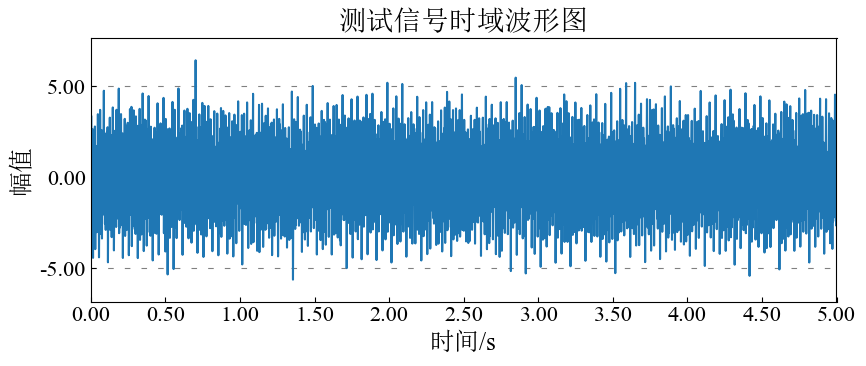

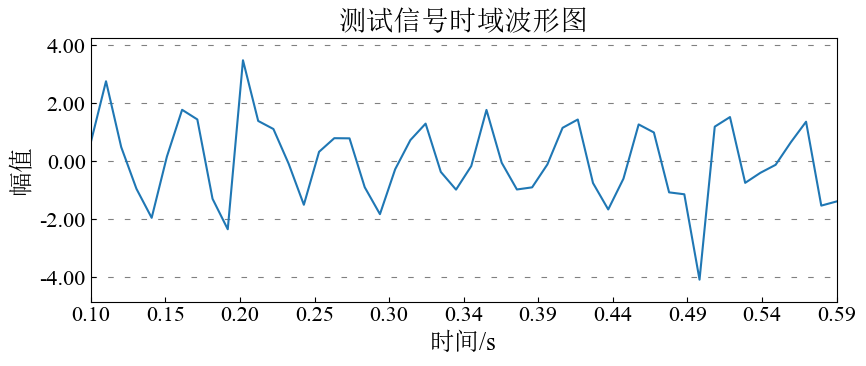

Signal(data=[-0.01115919  3.3914644   2.70231131 ... -2.4113022  -1.89974379
 -2.410297  ], fs=1000.0, label=测试信号)


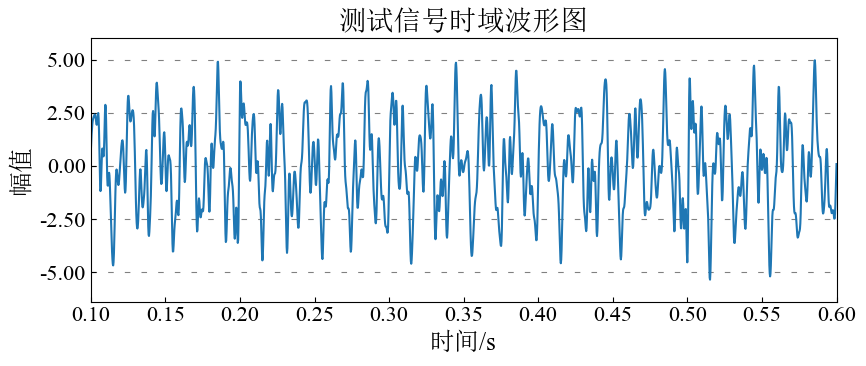

Signal(data=[-0.01115919  3.3914644   2.70231131 ... -2.4113022  -1.89974379
 -2.410297  ], fs=1000.0, label=测试信号)


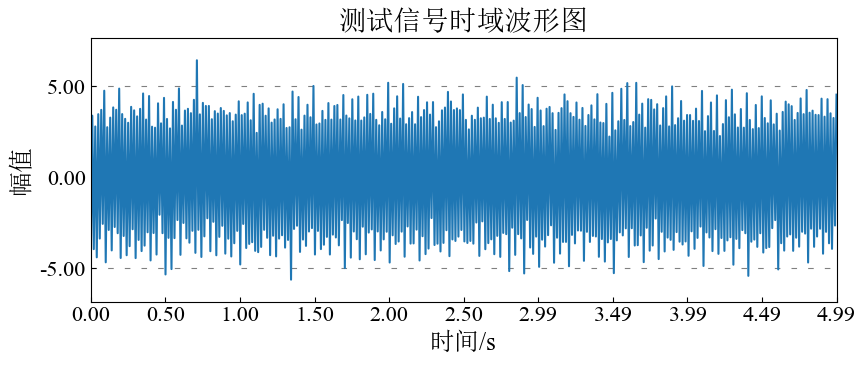

Signal(data=[-0.01115919  3.3914644   2.70231131 ... -2.4113022  -1.89974379
 -2.410297  ], fs=1000.0, label=测试信号)


In [3]:
from PySP.Signal_Module.SignalSampling import Resample

from PySP.Signal import Signal

try:
    Sig = Signal(data=Data,fs=fs,label='测试信号')
    Sig.plot()
    _Sig=Resample(Sig=Sig,fs_resampled=100.0,t0=0.1,T=0.5)
    _Sig.plot()
    print(Sig)
    _Sig=Resample(Sig=Sig,type='fft',fs_resampled=4000.0,t0=0.1,T=0.5)
    _Sig.plot()
    print(Sig)
    _Sig=Resample(Sig=Sig,type='extreme',fs_resampled=100.0)
    _Sig.plot()
    print(Sig)
except Exception as e:
    print(e)

### 1.3 Signal.Periodic()

仿真含噪准周期信号的采样参数: 
N: 2000
fs: 1000.0 Hz
t0: 0 s
dt: 0.001 s
T: 2.00 s
t1: 2.00 s
df: 0.5 Hz
fn: 500.00 Hz


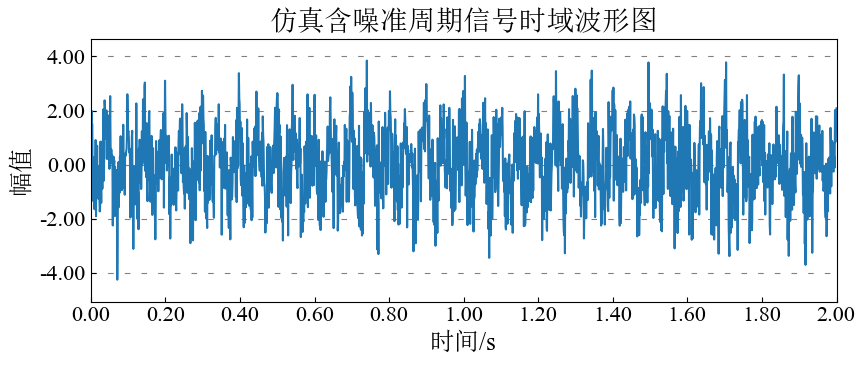

In [4]:
from PySP.Signal_Module.SimulateSignal import Periodic

try:
    Sig = Periodic(fs=1000.0,T=2.0,CosParams=((20,1,32),(50,0.5,0)),noise=1.0)
    print(repr(Sig))
    Sig.plot()
except Exception as e:
    print(e)

## 2. Plot模块测试

### 2.1 Plot.Plot()

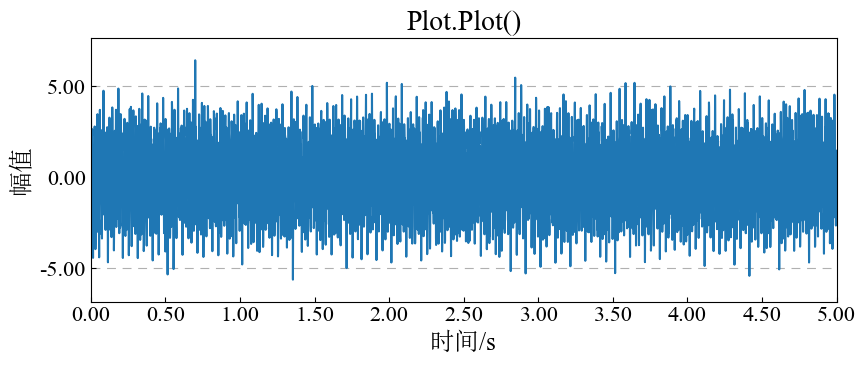

In [7]:
from PySP.Plot import Plot
from PySP.Signal import Signal

try:
    Sig = Signal(data=Data, fs=fs, label="测试信号")

    class TestPlot(Plot):

        def plot(self, Sig: 'Signal', **kwargs):

            def _draw_plot(ax, data):
                ax.plot(data.t_Axis, data.data, label=data.label)

            task_kwargs = self.kwargs
            task_kwargs.update(kwargs)

            task = {
                "data": Sig,
                "kwargs": task_kwargs,
                "plot_function": _draw_plot,
                "plugins": [],  # 初始化任务专属插件列表
            }
            self.tasks.append(task)
            return self
            
    test=TestPlot(
        xlabel="时间/s",
        ylabel="幅值",
        title="Plot.Plot()",
    ).plot(Sig).show()
except Exception as e:
    print(e)

### 2.2 Plot.LinePlot()

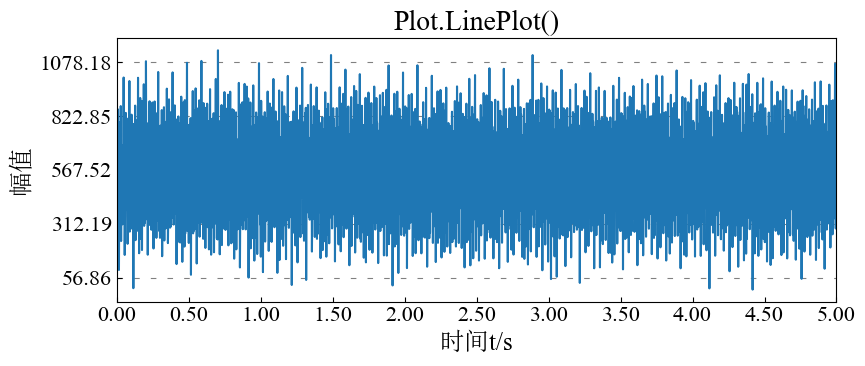

In [4]:
from PySP.Plot_Module.LinePlot import LinePlot

from PySP.Signal import Signal
from PySP.Signal_Module.SignalSampling import Resample
import matplotlib.pyplot as plt

try:
   Sig1 = Signal(data=100*(Data-np.min(Data)+1e-3), fs=fs, label="测试信号1")
   Sig2 = (Sig1 + 2) * 3+10
   Sig2.label = "测试信号2"
   Sig2 = Resample(Sig=Sig2, fs_resampled=200.0, t0=2.0, T=1.0)
   Plot = LinePlot(
      isSampled=True, xlabel="时间t/s", ylabel="幅值", title="Plot.LinePlot()"
   )
   fig,ax=Plot.TimeWaveform(Sig1).show(pattern='return')
   plt.show()
except Exception as e:
    print(e)

### 2.3 Plot.PeakfinderPlugin()

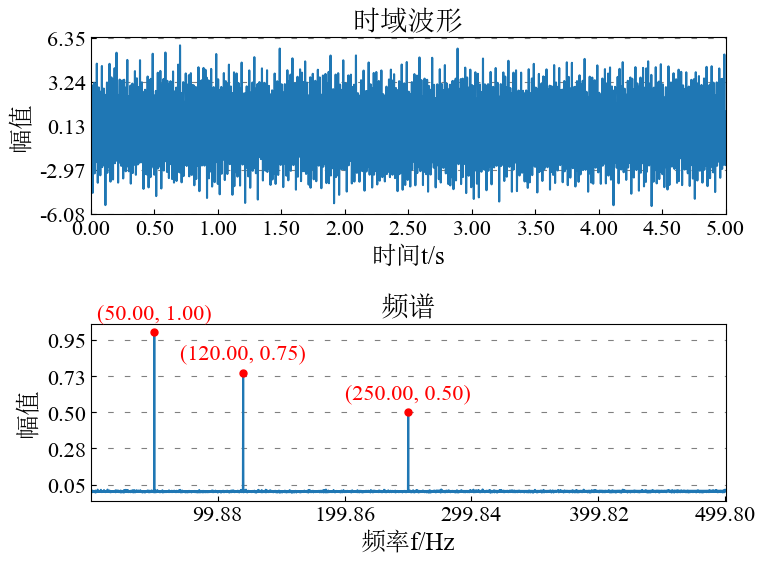

In [8]:
from PySP.Plot_Module.PlotPlugin import PeakfinderPlugin

from PySP.Signal import Signal
from scipy.fftpack import fft

try:
   Sig1 = Signal(data=Data, fs=fs, label="测试信号")
   Plot=LinePlot(isSampled=True,figsize=(8,3),xlabel="时间t/s", ylabel="幅值", title="Plot.LinePlot()")
   Plot.TimeWaveform(
      Sig1,title="时域波形"
   )
   F_x=np.abs(fft(Sig1.data))/Sig1.N
   Plot.Spectrum(Sig1.f_Axis,F_x)
   Plot.set_params_to_task(xlabel="频率f/Hz",xlim=(0,500),title="频谱")
   Plot.add_plugin_to_task(PeakfinderPlugin(distance=50,prominence=0.1))
   Plot=Plot.show()
except Exception as e:
   print(e)

## 3. Analysis模块测试

### 3.1 Analysis.Analysis()

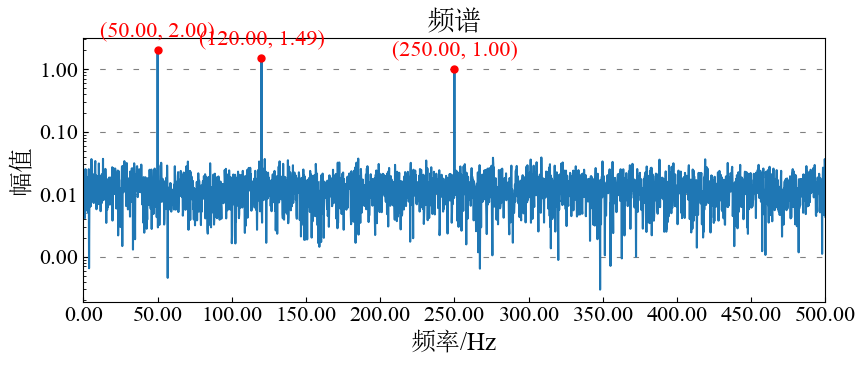

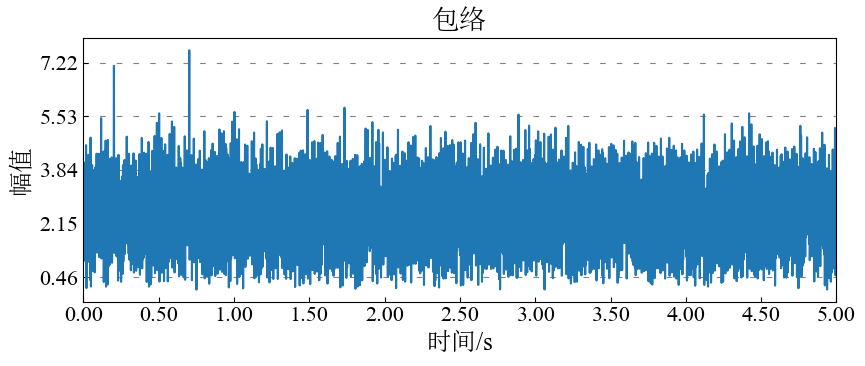

In [9]:
from PySP.Analysis import Analysis

from PySP.Signal import Signal
from PySP.Plot_Module.LinePlot import TimeWaveformFunc, FreqSpectrumFunc
from scipy.signal import hilbert
try:
    class TestAnalysis(Analysis):
        @Analysis.Plot(TimeWaveformFunc)
        def envelope(self):
            """包络分析"""
            analytic_signal = hilbert(self.Sig.data)
            amplitude_envelope = np.abs(analytic_signal)
            return Signal(data=amplitude_envelope, fs=self.Sig.fs, label="包络信号", t0=self.Sig.t0)
        
        @Analysis.Plot(FreqSpectrumFunc)
        def fft(self):
            """FFT频谱分析"""
            N = self.Sig.N
            Y = np.fft.fft(self.Sig.data)
            P2 = np.abs(Y / N)  # 双边频谱
            P1 = P2[: N // 2 + 1]  # 单边频谱
            P1[1:-1] = 2 * P1[1:-1]
            f = self.Sig.fs * np.arange(0, (N / 2 + 1)) / N
            return f, P1
        
    Sig = Signal(data=Data, fs=fs)
    analysis=TestAnalysis(
        Sig,
        isPlot=True,
        title="频谱",
    )
    analysis.fft()
    analysis.plot_kwargs['title']="包络"
    analysis.envelope()

except Exception as e:
    print(e)

## 3.BasicSP模块测试

### 3.1 BasicSP.window()

Signal(data=[0. 0. 0. ... 0. 0. 0.], fs=1000.0, label=汉宁窗)


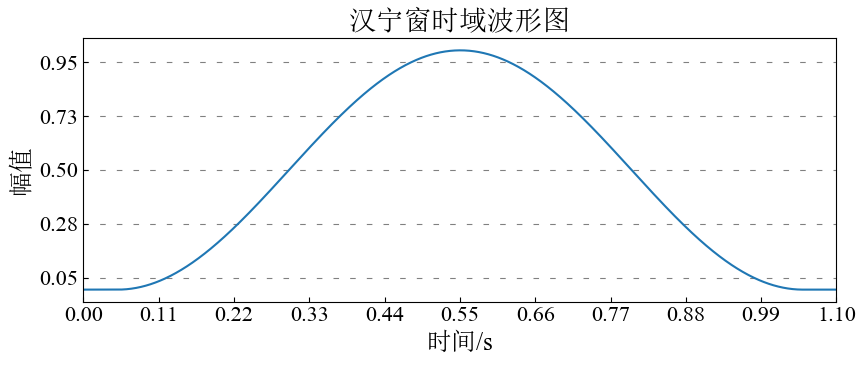

In [10]:
from PySP.Analysis_Module.SpectrumAnalysis import window

from PySP.Signal import Signal
try:
    data=window(type="汉宁窗",num=1000,padding=50)
    res=Signal(data=data,fs=1000.0,label="汉宁窗")
    print(res)
    res.plot()
except Exception as e:
    print(e)

### 3.2 BasicSP.Time_Analysis()

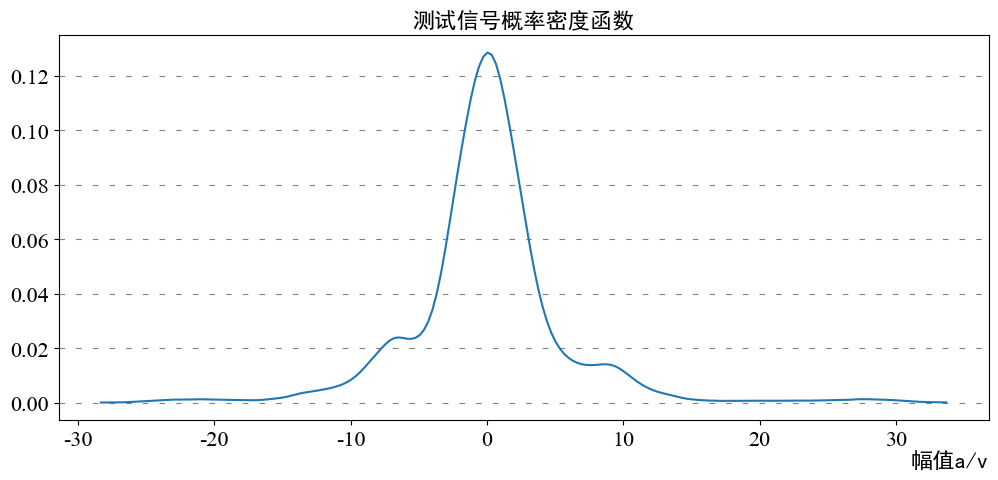

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>


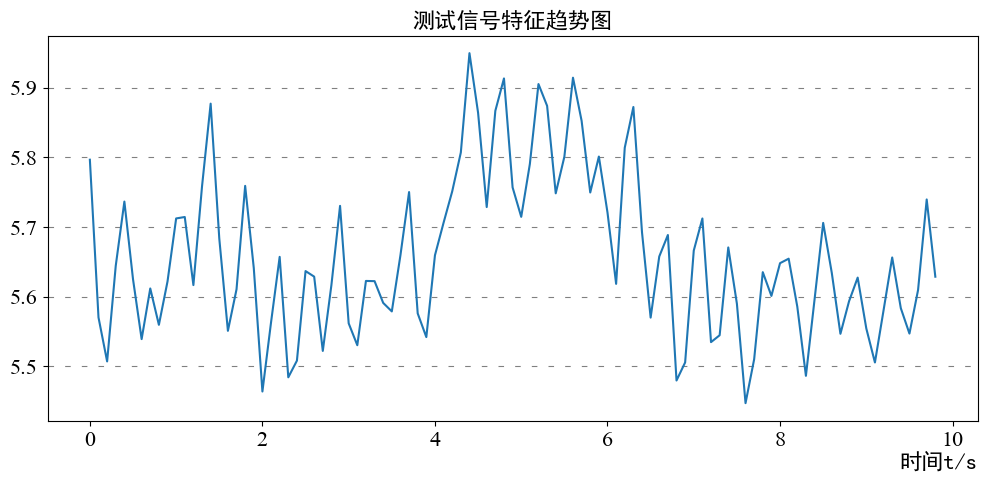

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>


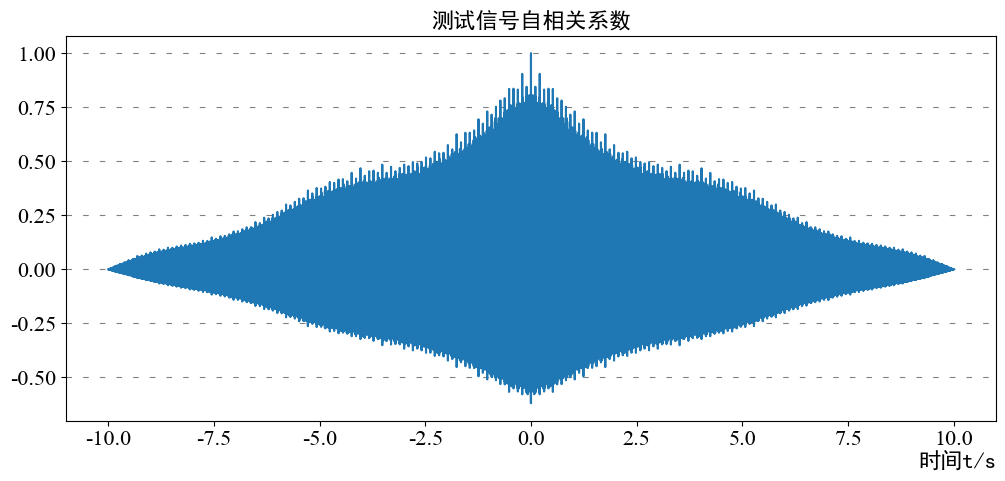

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>


In [ ]:
from PySP.BasicSP import Time_Analysis

try:
    Sig=Signal(data=Data,label='测试信号',fs=12000)
    # Time_Analysis.Psd()
    Sig=Time_Analysis(Sig=Sig,plot=True,plot_save=False,title=Sig.label+"概率密度函数",xlabel="幅值a/v").Pdf(samples=200)
    for i, r in enumerate(Sig):
        print(f"res{i+1}: ", type(r))
    # Time_Analysis.Trend()
    Sig=Time_Analysis(Sig=Sig,plot=True,plot_save=False,title=Sig.label+"特征趋势图",xlabel="时间t/s").Trend(Feature="有效值",step=0.1,SegLength=0.2)
    for i,r in enumerate(Sig):
        print(f"res{i+1}: ",type(r))
    # Time_Analysis.Autocorr()
    Sig=Time_Analysis(Sig=Sig,plot=True,plot_save=False,title=Sig.label+"自相关系数",xlabel="时间t/s").Autocorr(std=True,both=True)
    for i,r in enumerate(Sig):
        print(f"res{i+1}: ",type(r))
except Exception as e:
    print(e)

### 3.3 BasicSP.Frequency_Analysis()

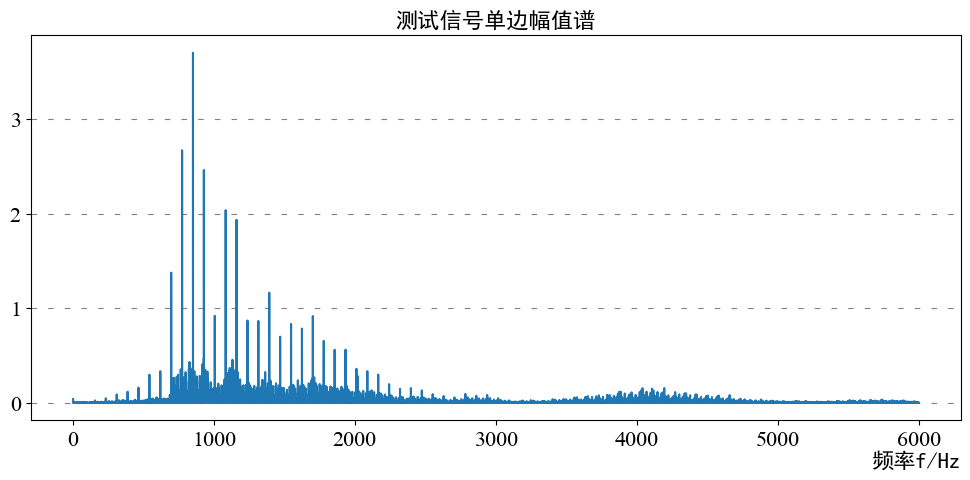

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>


In [ ]:
from PySP.BasicSP import Frequency_Analysis

try:
    Sig = Signal(data=Data, label="测试信号", fs=12000)
    # Frequency_Analysis.Cft()
    Sig = Frequency_Analysis(
        Sig=Sig,
        plot=True,
        plot_save=False,
        title=Sig.label + "单边幅值谱",
        xlabel="频率f/Hz",
    ).Cft(WinType="汉宁窗")
    for i, r in enumerate(Sig):
        print(f"res{i+1}: ", type(r))
except Exception as e:
    print(e)

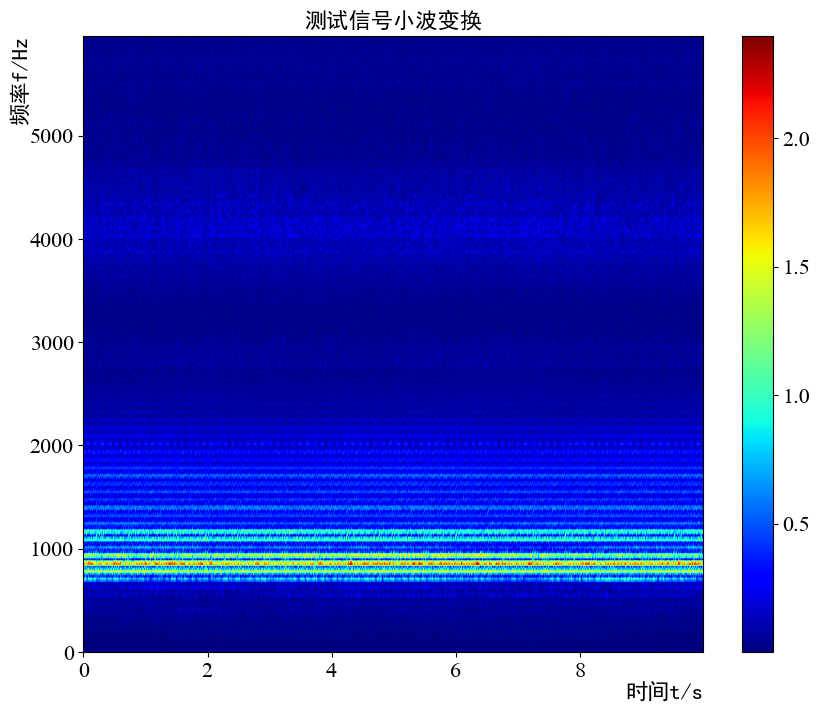

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>
res3:  <class 'numpy.ndarray'>


In [ ]:
from PySP.BasicSP import TimeFre_Analysis

try:
    Sig = Signal(data=Data, label="测试信号", fs=12000)
    # TimeFre_Analysis.Wavelet()
    Sig = TimeFre_Analysis(
        Sig=Sig,
        plot=True,
        plot_save=False,
        title=Sig.label + "小波变换",
        xlabel="时间t/s",
        ylabel="频率f/Hz",
    ).st_Cft(nperseg=513, nhop=128,WinType="汉宁窗")
    for i, r in enumerate(Sig):
        print(f"res{i+1}: ", type(r))
except Exception as e:
    print(e)